# Transfer Learning from Inception Model
by Gaetano Bonofiglio, Veronica Iovinella

## Introduction
In the previous notebook we have seen how long it takes to process a CNN for image recognition, even using $TensorFlow$, that is efficient enough compared to other tools, and very small pictures. Also the results are good for the dataset we've used, but not outstanding. 
The advantage of using Neural Networks in general is that, even if it takes long to train, the Network itself can be loaded and used offline with not much effort. The intuition here is to use a pre-trained CNN and transfer part of it to build a new classifier (in this case based on CIFAR-10 to make a comparison). 

## Inception Model
The Inception v3 model is a CNN by Google that takes weeks to train on a computer with 8 Tesla K40 GPUs and is impossible to train it on an ordinary PC. We will instead download the pre-trained Inception model and use it to classify images and then as a base to build the CIFAR-10 classifier we've seen in the previous notebook to then compare results. The advantages of Neural Networks are pretty much clear in this model that takes ages to train on a regular PC, but only a moment to use. 
The following picture shows the architecture of the model.

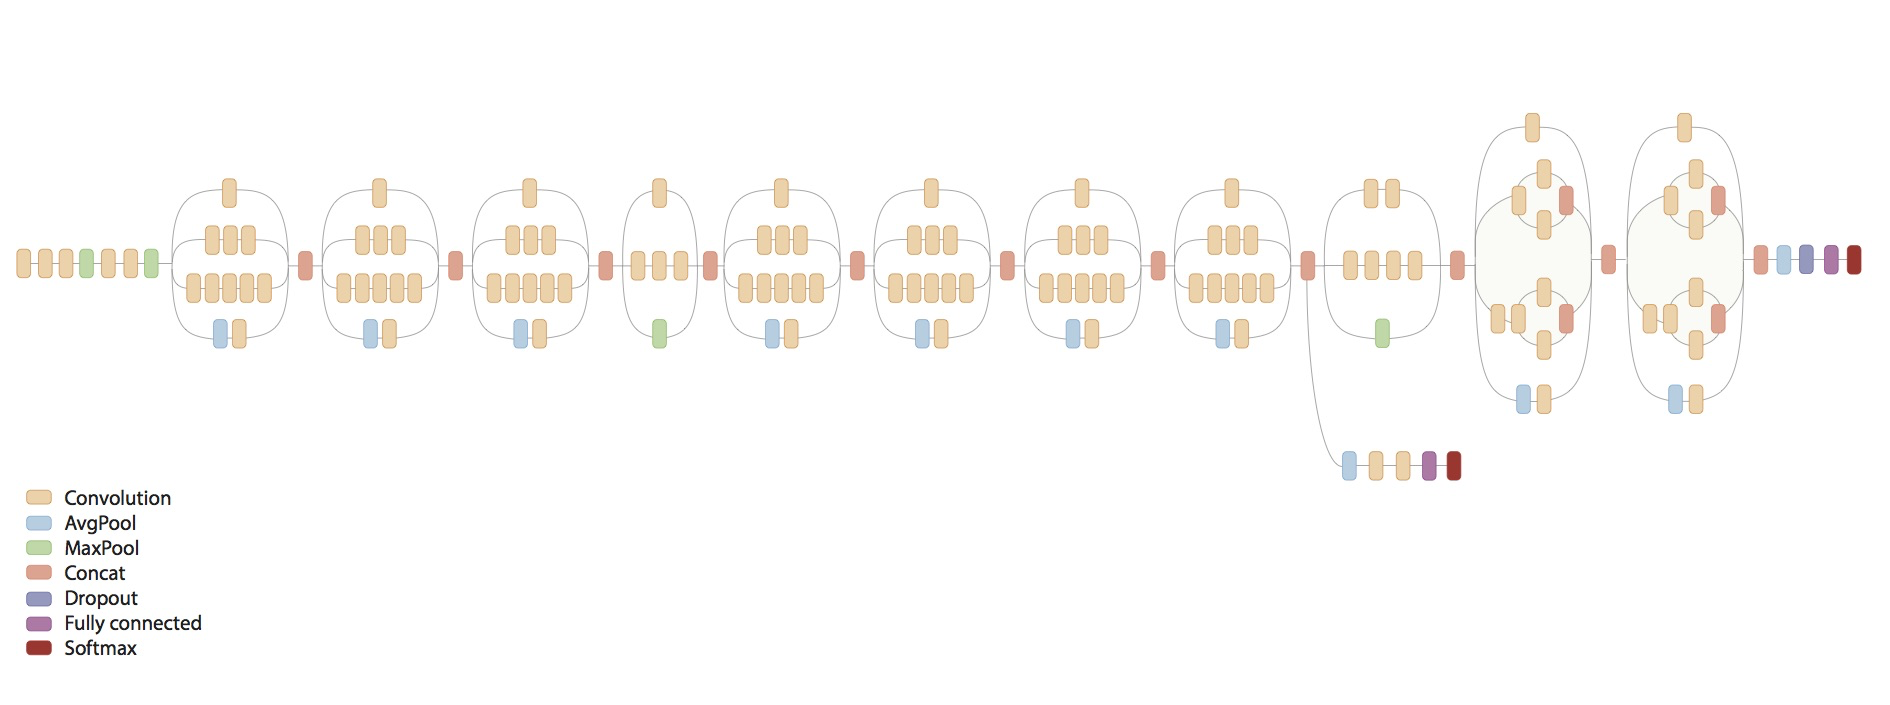

In [1]:
from IPython.display import Image, display
Image('images/04_inceptionV3Architecture.png')

The chart shows that Inception V3 is a Convolutional Neural Network with many layers and a very complicated structure. The two softmax layers are used during training and only the left one is used for classification. This is done in order to fight the vanishing gradient problem in very deep networks, a problem that we've partially experienced in the last notebook (the second convolutional layer had a much lower standard deviation compared to the first one). To avoid overfitting they use a regularization parameter, and they also admit in the research paper that they don't fully understand why Inception V3 works, but it actually outperforms every state of the art model before its release, and by a substantial margin.

It is trained using **ImageNet**, a common academic data set in machine learning for training an image recognition system, but with much higher resolution image compared to CIFAR-10, so it would require a lot of time to train. 

## Imports

In [2]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import os

from util import Util
u = Util()
from util_transfer import UtilTransfer
ut = UtilTransfer()

# Functions and classes for loading and using the Inception model.
import inception

tf.__version__

'0.9.0'

Now that the library is imported we can load the data from the CNN.

In [3]:
inception.maybe_download()

Data has apparently already been downloaded and unpacked.


## Image classification with Inception V3
The download of the Inception model also includes an example image, and a very low resolution one, to test if everything worked fine. We're going to use it to provide an example of classification.

In [4]:
# Load the Inception model so it is ready for classifying images.
model = inception.Inception()
# Helper-function for classifying and plotting images
def classify(image_path):
    display(Image(image_path))
    pred = model.classify(image_path=image_path)
    model.print_scores(pred=pred, k=10, only_first_name=True)
# Image path for the example picture to classify
image_path = os.path.join(inception.data_dir, 'cropped_panda.jpg')

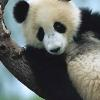

89.23% : giant panda
 0.86% : indri
 0.26% : lesser panda
 0.14% : custard apple
 0.11% : earthstar
 0.08% : sea urchin
 0.05% : forklift
 0.05% : soccer ball
 0.05% : go-kart
 0.05% : digital watch


In [5]:
classify(image_path)

### Reading the results
The result of the classify function is the same softmax layer we've seen in the previous notebook, with basically probabilities from 0 to 1, but this time over 1000 classes. In this case the model is pretty sure (almost 90%) that the image contains a panda. 
However sometimes the model is less sure about the result, but it's still interesting to see the various scores in the softmax layer, because it may offer a description of multimple objects contained in the image, as shown in the following examples. 

### More examples
The following examples are produced using images found on Google and specifically not from ImageNet, so not from the training set.

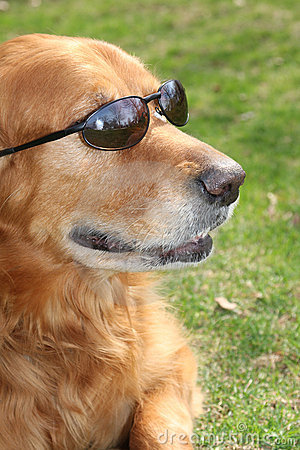

46.54% : golden retriever
16.03% : sunglass
12.33% : sunglasses
 4.01% : Pembroke
 1.04% : cocker spaniel
 0.92% : Cardigan
 0.78% : collie
 0.66% : Irish setter
 0.64% : Norfolk terrier
 0.41% : Pekinese


In [6]:
classify(image_path="imagesForClassification/dogWithSunglasses_1.jpg")

This example is outstanding. We've looked for a very uncommon picture to see how Inception V3 behaves and not only the classifier detects it's a golden retriever, so the specific breed of the dog, but also, with a cumulative 28%, that the picture contains sunglasses or dark glasses (for some reason the Inception model has been trained to recognize two very similar classes for sunglasses). 

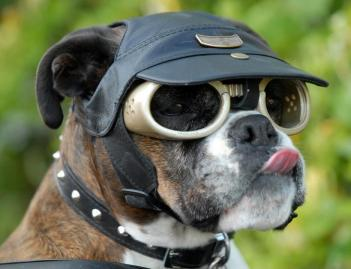

45.65% : muzzle
20.92% : boxer
10.58% : Boston bull
 1.41% : sunglass
 1.32% : Greater Swiss Mountain dog
 1.30% : sunglasses
 1.17% : Great Dane
 1.17% : Saint Bernard
 1.10% : bull mastiff
 0.77% : American Staffordshire terrier


In [7]:
classify(image_path="imagesForClassification/dogWithSunglasses_2.png")

Here the model detects multiple things in this very uncommon picture, some are right, some are wrong. First of all it thinks that it contains a muzzle, while it's actually a hat, pretty uncommon on a dog. Also overall there is a 35% chance this is a dog, but split in multiple breeds across the classes (with almost 21% bet on the Boston bull, which is true). Another interesting fact is that it detects the sunglasses, giving it 1.41% in the sunglass class and 1.3% in the sunglasses class. 

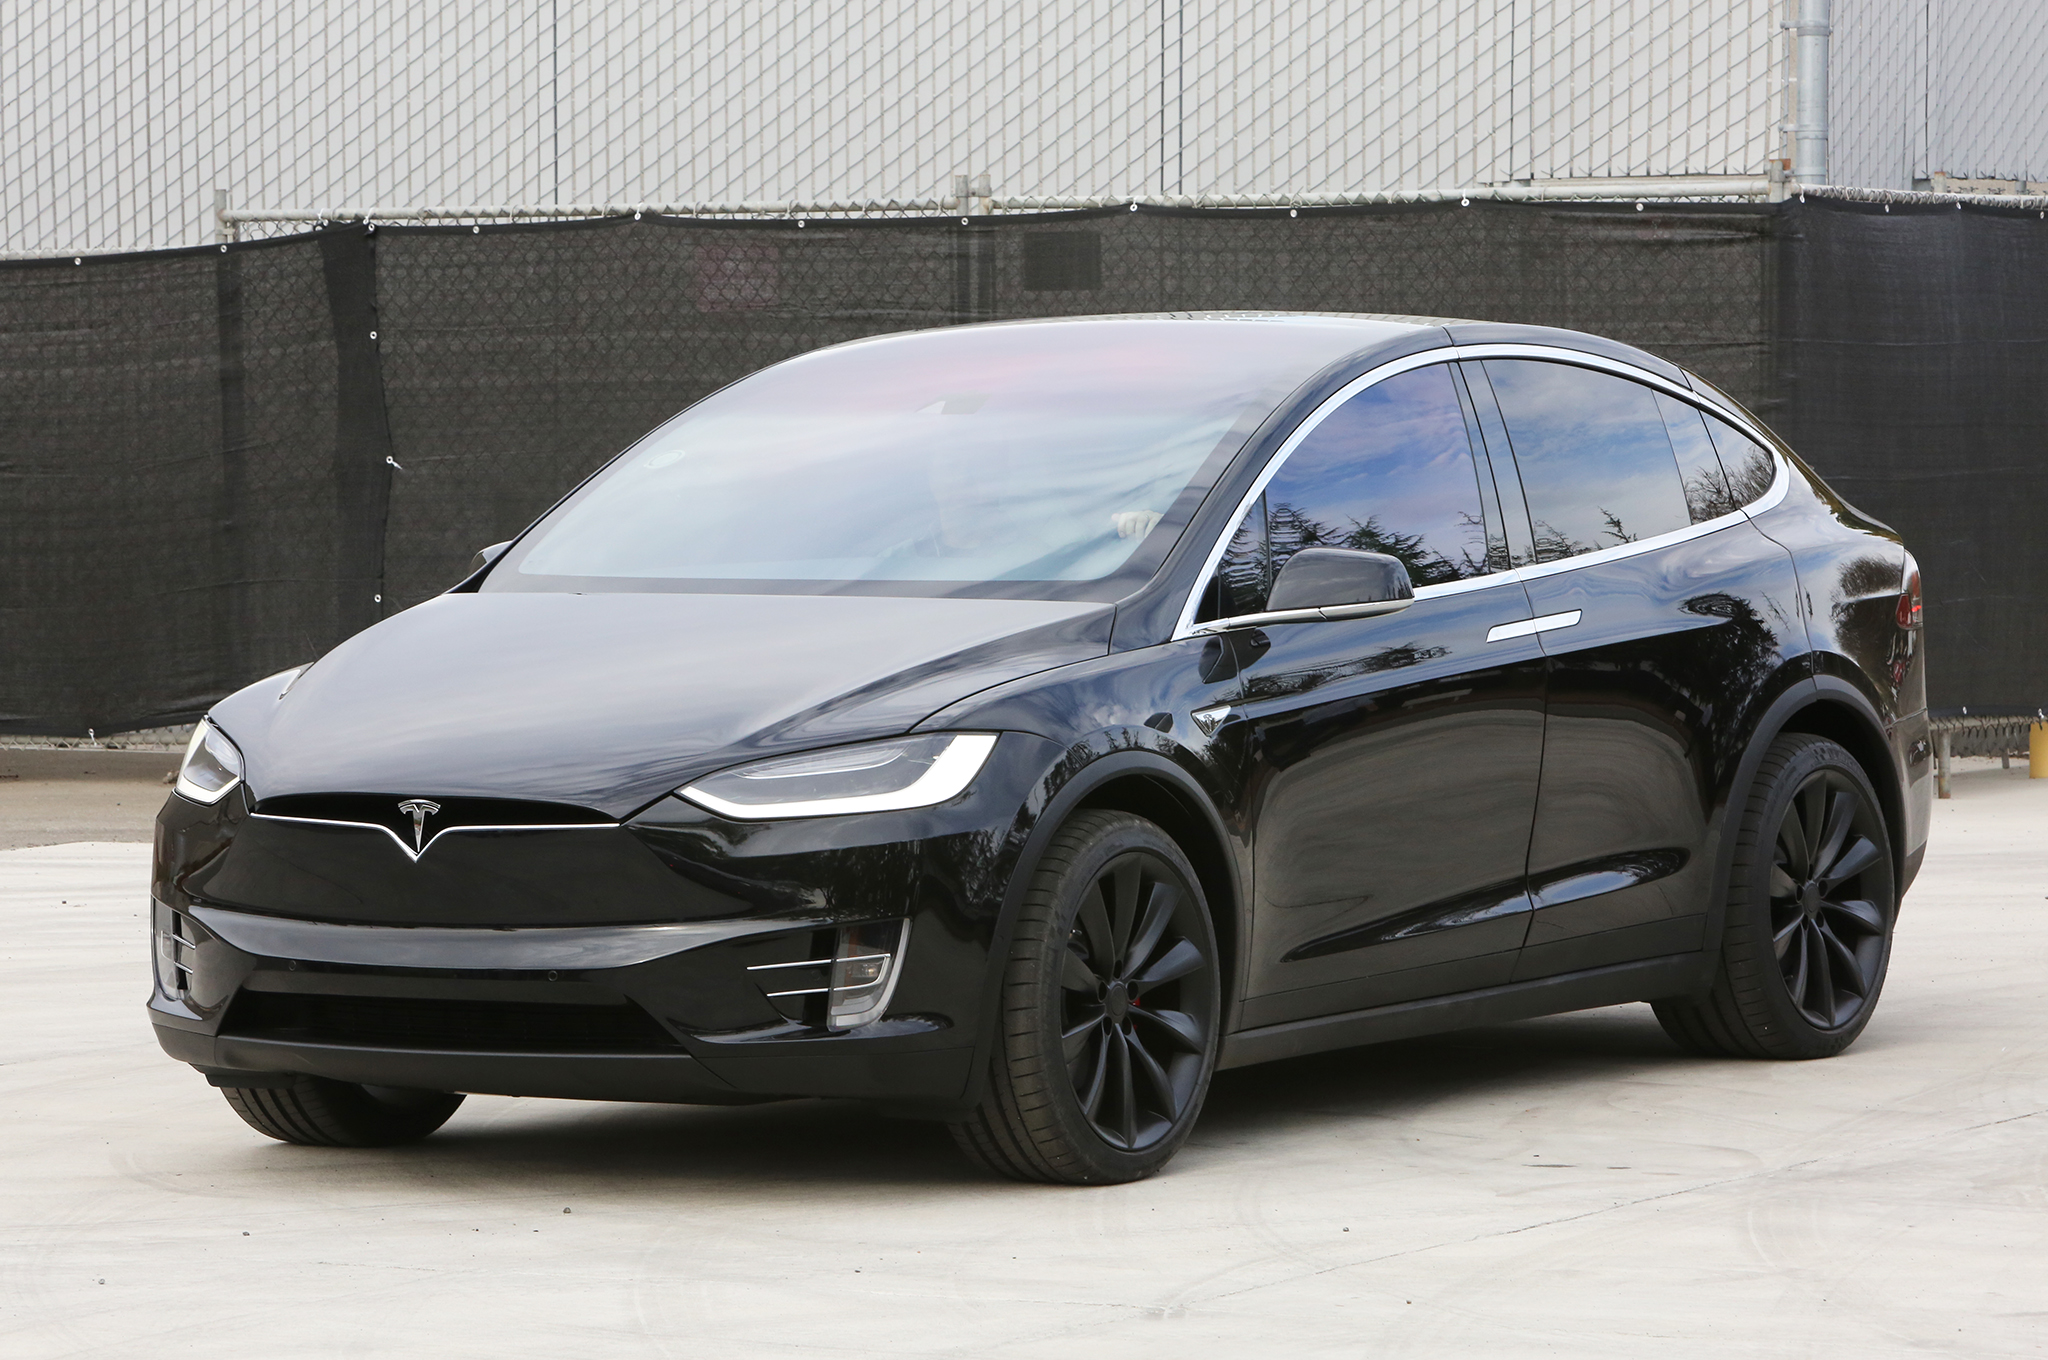

31.58% : beach wagon
17.37% : car wheel
15.57% : sports car
 9.04% : grille
 3.59% : convertible
 2.41% : minivan
 1.77% : limousine
 1.03% : racer
 0.44% : solar dish
 0.31% : cab


In [8]:
classify(image_path="imagesForClassification/tesla.jpg")

This last examples shows how well the model behaves on unanimated objects and overall objects similar to the one used during training. This one in particular is a very new car model, so it's not on ImageNet, however sport cars are very similar, so the model behaves pretty well. 

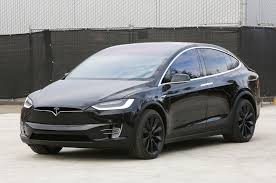

27.83% : sports car
18.11% : car wheel
 9.60% : beach wagon
 7.41% : grille
 4.87% : limousine
 3.42% : racer
 2.93% : pickup
 2.03% : minivan
 1.52% : convertible
 0.77% : car mirror


In [9]:
classify(image_path="imagesForClassification/tesla_resized.jpg")

Finally this one is a resized version of the previous image, almost 16 times smaller, and we can see how the model gives the same top 3 results. This will be important in the final notebook about adversary examples and solutions, where we'll see how CNNs behave when white noise is involved. Also the classification here is even more precise, because Inception model V3 is trained on 299x299 images (downscaled or upscaled from ImageNet).

## Transfer Learning
The goal is to re-use the pre-trained Inception model and replace the layer that does the final classification. This is called **Transfer Learning**, since we're not training the CNN from scratch or random values, but from a previous training, at least of the convolutional part. We're still going to train our classifier, but starting from features extracted by a very capable network. 

The goal is to produce a CNN that takes less time to train and is more accurate than the previous one, using the same CIFAR-10 dataset. 

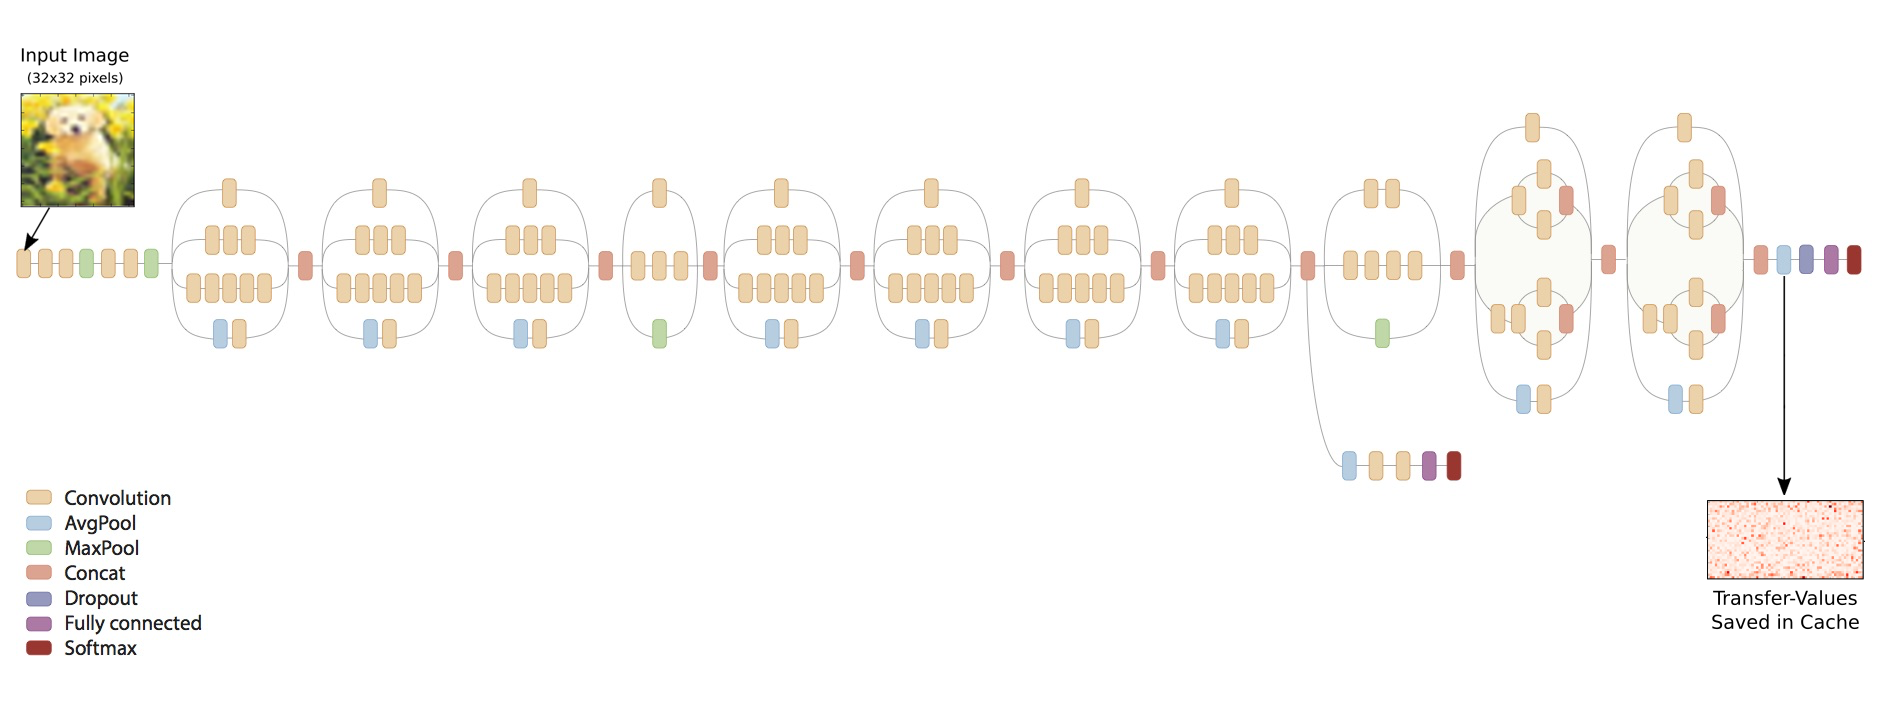

In [10]:
Image('images/04_architecture_1.png')

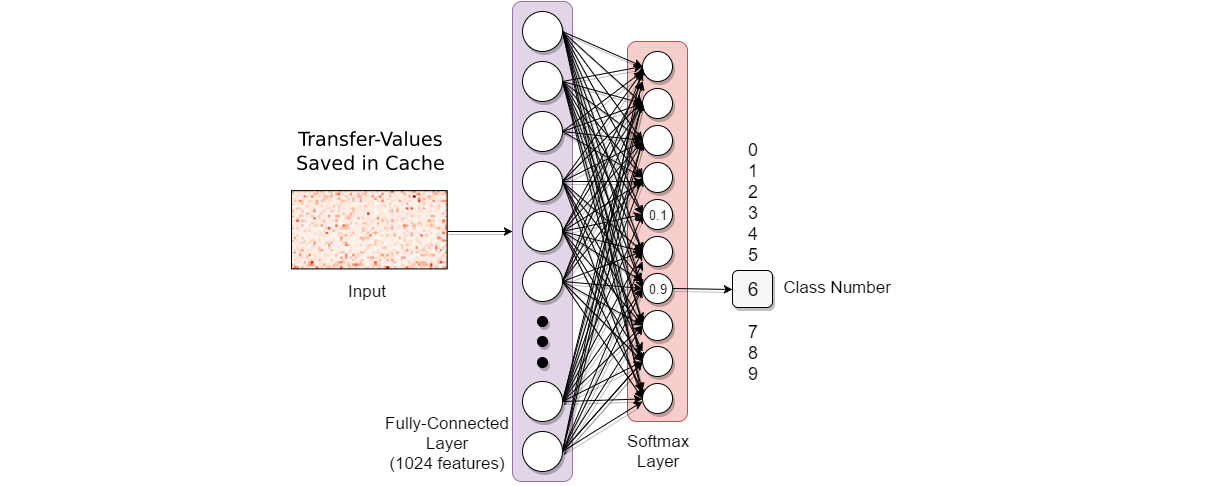

In [11]:
Image('images/04_architecture_2.png')

As the flowcharts show, we process images from the new data-set with the Inception model. Before the final classification layer, we save the **Transfer-Values** to a cache-file. This saves a lot of time of computation for extracting features from the new data-set.
Those Transfer-Values are then used as the input to a second neural network, which will be trained with the classes of the new data-set.
This means that the final classification will be based on the Trasfer-Values obtained from the Inception model.

## Imports

In [12]:
# We use Pretty Tensor to define the new classifier.
import prettytensor as pt

## Load Data for CIFAR-10

We load data from CIFAR-10 and set the path.

In [13]:
import cifar10
from cifar10 import num_classes
# cifar10.data_path = "data/CIFAR-10/"

cifar10.maybe_download_and_extract()

Data has apparently already been downloaded and unpacked.


We now load the class-names.

In [14]:
class_names = cifar10.load_class_names()
class_names

Loading data: data/CIFAR-10/cifar-10-batches-py/batches.meta


['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

We now load the training set and test set.

In [15]:
images_train, cls_train, labels_train = cifar10.load_training_data()

images_test, cls_test, labels_test = cifar10.load_test_data()


print("Size of:")
print("- Training-set:\t\t{}".format(len(images_train)))
print("- Test-set:\t\t{}".format(len(images_test)))

Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_1
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_2
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_3
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_4
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_5
Loading data: data/CIFAR-10/cifar-10-batches-py/test_batch
Size of:
- Training-set:		50000
- Test-set:		10000


### Helper-function for plotting images


In [16]:
def plot_images(images, cls_true, cls_pred=None, smooth=True): 
    u.plot_images_2(images=images, cls_true=cls_true, class_names=class_names, cls_pred=cls_pred, smooth=smooth)

### Plot a few images to test

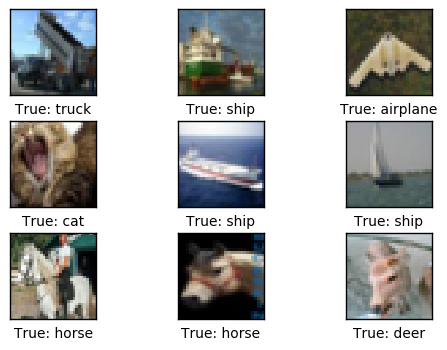

In [17]:
# Get the first images from the test-set.
images = images_test[50:59]

# Get the true classes for those images.
cls_true = cls_test[50:59]

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true, smooth=False)

### Download and Load the Inception Model

In [18]:
# inception.data_dir = 'inception/'
cache_dir = "cache/"
inception.maybe_download()

model = inception.Inception()

Data has apparently already been downloaded and unpacked.


## Calculate Transfer-Values
We import a helper-function for caching the transfer-values of the Inception model.

Since CIFAR returns pixels between 0 and 1, while Inception model needs pixel colors to be scaled between 0 and 255, we need to multiply them. We are doing it for both training and test sets.

In [19]:
from inception import transfer_values_cache

file_path_cache_train = os.path.join(cache_dir, 'inception_cifar10_train.pkl')
file_path_cache_test = os.path.join(cache_dir, 'inception_cifar10_test.pkl')

images_scaled = images_train * 255.0

transfer_values_train = transfer_values_cache(cache_path=file_path_cache_train,
                                              images=images_scaled,
                                              model=model)

images_scaled = images_test * 255.0

transfer_values_test = transfer_values_cache(cache_path=file_path_cache_test,
                                             images=images_scaled,
                                             model=model)

- Data loaded from cache-file: cache/inception_cifar10_train.pkl
- Data loaded from cache-file: cache/inception_cifar10_test.pkl


(10000, 2048)

In [ ]:
transfer_values_train.shape

In [ ]:
transfer_values_test.shape

### Helper-function for plotting Transfer-Values

In [20]:
def plot_transfer_values(i): 
    u.plot_transfer_values(i=i, images=images_test, transfer_values=transfer_values_test)

Input image:


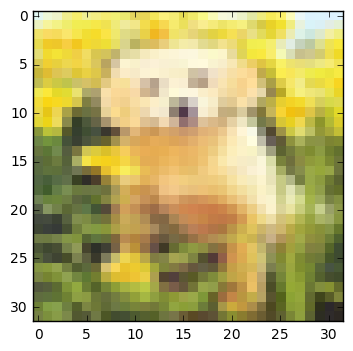

Transfer-values for the image using Inception model:


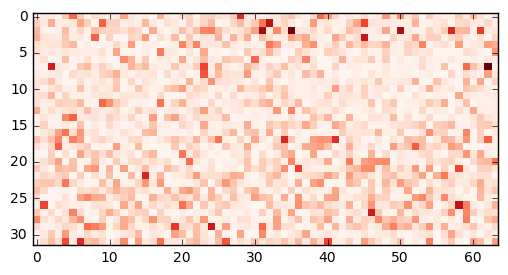

In [21]:
plot_transfer_values(190)

## Analysis of Transfer-Values
We want to be sure that the Transfer-Values obtain from the Inception model contain enough information to correctily classify the images. 
To do so we apply a clustering algorithm to plot the Transfer-Values and see if there is any correlation between those clusters and the classes from the data-set.

First, since the array-lenght of the Transfer-Values is 2048, we need to dimensionally reduce them to an array-lenght of 2. We are going to do that using two different algorithms: PCA and t-SNE. This is because t-SNE retains more information, but it's very slow, while PCA is linear, so it's faster while less precise.

**t-distributed stochastic neighbor embedding (t-SNE)** is a machine learning algorithm for dimensionality reduction. It is a nonlinear dimensionality reduction technique that is particularly well-suited for embedding high-dimensional data into a space of two or three dimensions, which can then be visualized in a scatter plot. Specifically, it models each high-dimensional object by a two- or three-dimensional point in such a way that similar objects are modeled by nearby points and dissimilar objects are modeled by distant points.

The analysis will be done on a subsample of 1000 Transfer-Values.

In [22]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

transfer_values = transfer_values_train[0:1000]
cls = cls_train[0:1000]

# First we reduce the dimensions from 2048 to 50 using PCA
pca = PCA(n_components=50)
transfer_values_50d = pca.fit_transform(transfer_values)

# Then we reduce to 2 dimensions using t-SNE
tsne = TSNE(n_components=2)
transfer_values_reduced = tsne.fit_transform(transfer_values_50d)

# Helper function to plot the scatter
def plot_scatter(values, cls): 
    u.plot_scatter(values=values, cls=cls, num_classes=num_classes)

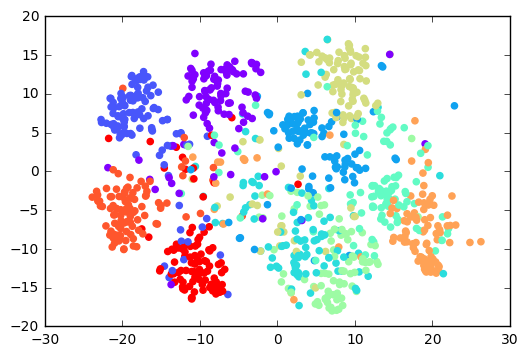

In [23]:
plot_scatter(transfer_values_reduced, cls)

As we can see, the Transfer-Values seem to be well divided into clusters, despite the approximation. Even a clustering algorithm may be able to classify the images at this point with decent accuracy. 

## Classification of Transfer-Values
We will now code a new classifier using $TensorFlow$ and **PrettyTensor** as in the previous notebook. This time the classifier has one less layer since we rely more on the pre-trained convolutional network, and doing so will save a lot of computation time. 

The new network, as said before, will take the transfer values as input (x) and then output the classes from the CIFAR-10 dataset. 

### Placeholder Variables

In [24]:
transfer_len = model.transfer_len
x = tf.placeholder(tf.float32, shape=[None, transfer_len], name='x')
y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')
y_true_cls = tf.argmax(y_true, dimension=1)

### Neural Network
Using **PrettyTensor** to describe it at a higher level.

In [25]:
# Wrap the transfer-values as a Pretty Tensor object.
x_pretty = pt.wrap(x)

with pt.defaults_scope(activation_fn=tf.nn.relu):
    y_pred, loss = x_pretty.\
        fully_connected(size=1024, name='layer_fc1').\
        softmax_classifier(class_count=num_classes, labels=y_true)

### Optimization Method

In [26]:
# Keeps track of the number of optimization iterations performed.
global_step = tf.Variable(initial_value=0,
                          name='global_step', trainable=False)
# Adam Optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(loss, global_step)

### Classification Accuracy

In [27]:
y_pred_cls = tf.argmax(y_pred, dimension=1)
correct_prediction = tf.equal(y_pred_cls, y_true_cls)
# The classification accuracy is calculated by first type-casting the array of booleans to floats, 
# so that False becomes 0 and True becomes 1, and then taking the average of these numbers.
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

## TensorFlow Run
As before, we need to create the $TensorFlow$ session and then initialize the variables.

In [28]:
session = tf.Session()
session.run(tf.initialize_all_variables())

### Helper-function to get a random training-batch
As in all the previous notebooks, we need to use small batches for training, or the machine may run out of memory.

In [29]:
train_batch_size = 64

def random_batch():
    ut.random_batch(transfer_values_train, train_batch_size, labels_train)

### Helper-function to perform optimization

In [30]:
def optimize(num_iterations):
    ut.optimize(num_iterations, transfer_values_train, train_batch_size, 
                labels_train, session, global_step, optimizer, accuracy, x, y_true)

### Helper-function to plot example errors
This function plots examples of images from the test-set that have been mis-classified.

In [31]:
def plot_example_errors(cls_pred, correct):
    ut.plot_example_errors(cls_pred, correct, images_test, cls_test, plot_images, images)

### Helper-function to plot confusion matrix

In [32]:
def plot_confusion_matrix(cls_pred):
    ut.plot_confusion_matrix(cls_pred, cls_test, num_classes, class_names)

### Helper-functions for calculating classifications
This function calculates the predicted classes of images and also returns a boolean array whether the classification of each image is correct.

In [33]:
# Split the data-set in batches of this size to limit RAM usage.
batch_size = 256

def predict_cls(transfer_values, labels, cls_true):
    # Number of images.
    num_images = len(transfer_values)
    # Allocate an array for the predicted classes which
    # will be calculated in batches and filled into this array.
    cls_pred = np.zeros(shape=num_images, dtype=np.int)
    # Now calculate the predicted classes for the batches.
    i = 0
    while i < num_images:
        # The ending index for the next batch is denoted j.
        j = min(i + batch_size, num_images)
        # Create a feed-dict with the images and labels
        # between index i and j.
        feed_dict = {x: transfer_values[i:j],
                     y_true: labels[i:j]}
        # Calculate the predicted class using TensorFlow.
        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)
        # Set the start-index for the next batch to the end-index of the current batch.
        i = j
    # Create a boolean array whether each image is correctly classified.
    correct = (cls_true == cls_pred)
    return correct, cls_pred

### Helper-functions for the classification accuracy
This function calculates the classification accuracy given a boolean array whether each image was correctly classified.

E.g. classification_accuracy([True, True, False, False, False]) = 2/5 = 0.4. The function also returns the number of correct classifications.

In [34]:
def classification_accuracy(correct):
    ut.classification_accuracy(correct)

### Helper-function for showing the performance
This function prints the classification accuracy on the test-set.

In [35]:
def print_test_accuracy(show_example_errors=False, show_confusion_matrix=False):
    ut.print_test_accuracy(show_example_errors, show_confusion_matrix, transfer_values_test, 
                           labels_test, cls_test, batch_size, images_test, plot_images, images, 
                           num_classes, class_names, predict_cls)

## Results
We'll now see the results before and after the optimizations. 

### Performance before optimization

Accuracy on Test-Set: 7.0% (700 / 10000)
Confusion Matrix:
[ 45   4   0  58 145 244   0 472  27   5] (0) airplane
[124   1   0 121 157  77   0 499  21   0] (1) automobile
[ 60  16   3 352  90 137   0 265  76   1] (2) bird
[ 58   3   9 196 255  65   0 361  39  14] (3) cat
[ 36   9  20 343 180  33   0 151 218  10] (4) deer
[ 55   9   7 225 227  54   0 355  55  13] (5) dog
[ 60   8  13 194  76  68   0 542  36   3] (6) frog
[ 16   1  37 304 192  35   0 205 195  15] (7) horse
[ 12   1   6  59 169 228   0 483  14  28] (8) ship
[ 38   0   1  80 204  27   0 642   6   2] (9) truck
 (0) (1) (2) (3) (4) (5) (6) (7) (8) (9)


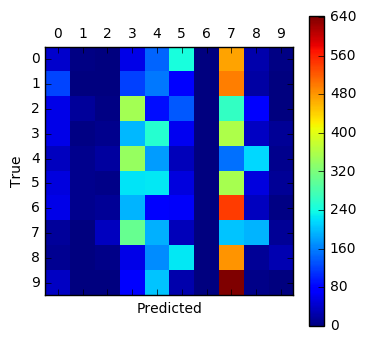

In [36]:
print_test_accuracy(show_example_errors=False, show_confusion_matrix=True)

### Performance after 10000 optimization iterations
There is no need to save checkpoints this time, because 10000 iterations do not take so long to compute compared to the 100000 of the previous notebook. Also we're now training only one fully connected layer instead of two fully connected layers and two convolutional layers. That's the main advantage of using transfer learning.

In [37]:
optimize(num_iterations=10000)

Global Step:    100, Training Batch Accuracy:  85.9%
Global Step:    200, Training Batch Accuracy:  84.4%
Global Step:    300, Training Batch Accuracy:  81.2%
Global Step:    400, Training Batch Accuracy:  87.5%
Global Step:    500, Training Batch Accuracy:  85.9%
Global Step:    600, Training Batch Accuracy:  95.3%
Global Step:    700, Training Batch Accuracy:  89.1%
Global Step:    800, Training Batch Accuracy:  90.6%
Global Step:    900, Training Batch Accuracy:  92.2%
Global Step:   1000, Training Batch Accuracy:  96.9%
Global Step:   1100, Training Batch Accuracy:  89.1%
Global Step:   1200, Training Batch Accuracy:  90.6%
Global Step:   1300, Training Batch Accuracy:  90.6%
Global Step:   1400, Training Batch Accuracy:  92.2%
Global Step:   1500, Training Batch Accuracy: 100.0%
Global Step:   1600, Training Batch Accuracy:  90.6%
Global Step:   1700, Training Batch Accuracy:  92.2%
Global Step:   1800, Training Batch Accuracy:  92.2%
Global Step:   1900, Training Batch Accuracy: 

As we can see, after only 1000 iterations the error on the training set was already pretty low. At this point going over 10000 iterations may result in overfitting and we want to avoid that. 

Accuracy on Test-Set: 90.5% (9045 / 10000)
Example errors:


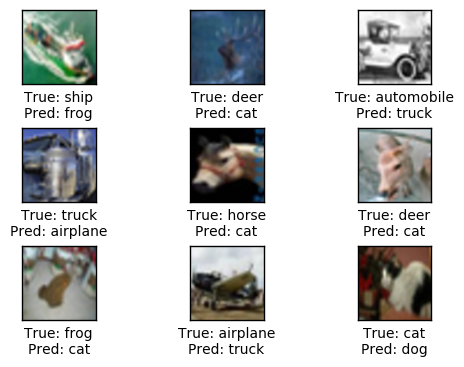

Confusion Matrix:
[907   7  13   9   1   3   1   1  47  11] (0) airplane
[  8 941   1   5   0   4   0   1  11  29] (1) automobile
[ 18   0 882  33  24  12  24   3   3   1] (2) bird
[  4   1  11 862  10  84  17   5   4   2] (3) cat
[  4   0  20  42 867  15  28  20   3   1] (4) deer
[  3   0   8  87   9 879   4   8   2   0] (5) dog
[  3   0  12  30  12  12 928   1   2   0] (6) frog
[  8   0  12  28  25  46   2 873   3   3] (7) horse
[ 24   2   0   3   0   1   1   0 965   4] (8) ship
[  6  29   3   3   0   0   1   1  16 941] (9) truck
 (0) (1) (2) (3) (4) (5) (6) (7) (8) (9)


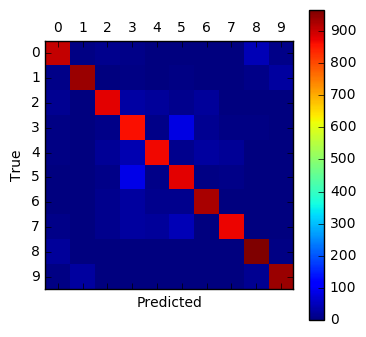

In [38]:
print_test_accuracy(show_example_errors=True, show_confusion_matrix=True)

As before, the NN finds difficult to discriminate between similar animals, probably because the pictures are very small, and the Transfer-Values could extract similar features. However 90.5% is a good accuracy on CIFAR-10 (the attempt in the previous notebook could only reach 80% accuracy after hours of training).

## Close TensorFlow Session

In [39]:
model.close()
session.close()

## Performance
The computation of the Transfer Values took about 3 hours, running on the same machine of the previous notebooks, a virtual Linux machine with 2 cores on a 3.5 GHz CPU and SSD drive. 

The training took much less time, about 6 minutes, performing just 10000 optimizations, while the previous CNN took 12 hours for 100000 iterations. We could use less iterations this time because the maximum accuracy is reached before, and doing more would result in overfitting. Also, the NN is much smaller, because we don't train any convolutional layer but we use the Transfer Values instead.

The accuracy is a nice 90%, with respect to the previous 80%.

## Conclusion
Comparing the performance with the previous notebook, in which we used a CNN without Inception Model and Transfer Learning, we can clearly see the convinience: previously it took a little more than 12 hours to complete the training, while here it took only 3 hours to compute the Transfer Values, and a few more minutes for the training.
We also noticed an increment in accuracy, reaching a significant 90% with respect to 80% reached without Transfer Learning.

Next, we are going to analyze the performance of Inception Model and Transfer Learning working on a custom dataset with few examples, explore Deep Dream to better understand what happens inside a CNN, and finally try to propouse adversary examples to find the limits of CNN and investigate possible solutions.